In [1]:
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

##### Get Ready

In [2]:
# Preparing dataset

fhv_january = pd.read_parquet('./data/fhv_tripdata_2021-01.parquet')
fhv_january.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [3]:
# Question 1: Number of records in Jan 2021 FHV data

print("Number of records in Jan 2021 FHV data: ", len(fhv_january))

Number of records in Jan 2021 FHV data:  1154112


In [4]:
# Question 2: Average duration in Jan 2021 FHV

fhv_january['duration'] = fhv_january.dropOff_datetime - fhv_january.pickup_datetime
fhv_january['duration'] = fhv_january['duration'].apply(lambda td: td.total_seconds() / 60)

avg_duration = fhv_january.duration.mean()

print("Average duration in Jan 2021 FHV: ", avg_duration)

Average duration in Jan 2021 FHV:  19.1672240937939


##### Data Preparation

<AxesSubplot:xlabel='duration', ylabel='Count'>

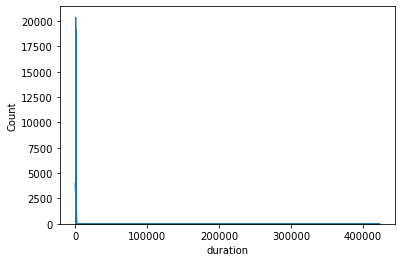

In [5]:
# Check distribution and Outliers data in Duration Variable

sns.histplot(data=fhv_january['duration'], kde=True, element='step')

In [6]:
# Keep only the records where the duration was between 1 and 60 minutes (inclusive)

condition = (fhv_january.duration >= 1) & (fhv_january.duration <= 60)

new_fhv_january = fhv_january[condition]

print("Many records were dropped: ", len(fhv_january) - len(new_fhv_january))

Many records were dropped:  44286


In [7]:
# Replace missing values

new_fhv_january[['PUlocationID', 'DOlocationID']] = new_fhv_january[['PUlocationID', 'DOlocationID']].fillna('-1')
new_fhv_january[['PUlocationID', 'DOlocationID']]

/tmp/ipykernel_3985/1277116010.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_fhv_january[['PUlocationID', 'DOlocationID']] = new_fhv_january[['PUlocationID', 'DOlocationID']].fillna('-1')


,PUlocationID,DOlocationID
0,-1,-1
1,-1,-1
3,-1,72.0
4,-1,61.0
5,-1,71.0
...,...,...
1154107,7.0,7.0
1154108,44.0,91.0
1154109,171.0,171.0
1154110,15.0,15.0


In [8]:
# Question 3: Fraction of missing values

new_fhv_january[['PUlocationID', 'DOlocationID']] = new_fhv_january[['PUlocationID', 'DOlocationID']].astype('str')

percentage_na = len(new_fhv_january[new_fhv_january['PUlocationID'] == '-1']) / len(new_fhv_january['PUlocationID'])

print("Fraction of missing values: {:.2%}".format(percentage_na))

/tmp/ipykernel_3985/1343686599.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_fhv_january[['PUlocationID', 'DOlocationID']] = new_fhv_january[['PUlocationID', 'DOlocationID']].astype('str')


Fraction of missing values: 83.53%


In [9]:
# One-Hot Encoding

train_data = new_fhv_january[['PUlocationID', 'DOlocationID']].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_data)

In [10]:
# Question 4: Dimensionality after OHE

print("Dimensionality after OHE: ", X_train.shape[1])

Dimensionality after OHE:  525


##### Training Models

In [11]:
# Question 5: RMSE on train

y_train = new_fhv_january['duration'].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
score = mean_squared_error(y_train, y_pred, squared=False)

print("RMSE on Train: ", score)

RMSE on Train:  10.528519107211805


##### Evaluating Model

In [12]:
# Make function for get data

def get_data(path, dict_vectorizer):
    
    data = pd.read_parquet(path)

    data['duration'] = data.dropOff_datetime - data.pickup_datetime
    data['duration'] = data['duration'].apply(lambda td: td.total_seconds() / 60)
    
    condition = (data.duration >= 1) & (data.duration <= 60)
    data = data[condition]

    data[['PUlocationID', 'DOlocationID']] = data[['PUlocationID', 'DOlocationID']].fillna('-1')

    X = data[['PUlocationID', 'DOlocationID']].astype('str').to_dict(orient='records')
    X = dict_vectorizer.transform(X)
    
    y = data['duration']

    return X, y
    

In [13]:
# Question 6: RMSE on validation

X_valid, y_valid = get_data('./data/fhv_tripdata_2021-02.parquet', dv)

print(X_valid.shape)


(990113, 525)


In [14]:
y_pred_val = lr.predict(X_valid)
score_val = mean_squared_error(y_valid, y_pred_val, squared=False)

print("RMSE on Validation: ", score_val)

RMSE on Validation:  11.014283195752167
